# Import Libraries and Data

In [430]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas_datareader.data as web
from plotly.subplots import make_subplots
from datetime import datetime
import numpy as np
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [431]:
''' Load the consumption and prices data from Excel files, skip first 2 rows '''

consumption = pd.read_excel("Data/ConsumptionData.xlsx", skiprows=2)
prices = pd.read_excel("Data/MonthlyRetailPrices.xlsx", skiprows=2)

------------------------------------------------------------------------------------------------------------

# Consumption Data

## Cleaning and Transforming Consumption Data

In [432]:
''' View Consumption data to ensure it loaded correctly'''

consumption.head(10)

,Date,U.S. Product Supplied of Finished Motor Gasoline (Thousand Barrels),East Coast (PADD 1) Product Supplied of Finished Motor Gasoline (Thousand Barrels),Midwest (PADD 2) Product Supplied of Finished Motor Gasoline (Thousand Barrels),Gulf Coast (PADD 3) Product Supplied of Finished Motor Gasoline (Thousand Barrels),Rocky Mountain (PADD 4) Product Supplied of Finished Motor Gasoline (Thousand Barrels),West Coast (PADD 5) Product Supplied of Finished Motor Gasoline (Thousand Barrels)
0,1945-01-15,40310,NaN,NaN,NaN,NaN,NaN
1,1945-02-15,38690,NaN,NaN,NaN,NaN,NaN
2,1945-03-15,42511,NaN,NaN,NaN,NaN,NaN
3,1945-04-15,45351,NaN,NaN,NaN,NaN,NaN
4,1945-05-15,47515,NaN,NaN,NaN,NaN,NaN
5,1945-06-15,47091,NaN,NaN,NaN,NaN,NaN
6,1945-07-15,51409,NaN,NaN,NaN,NaN,NaN
7,1945-08-15,56974,NaN,NaN,NaN,NaN,NaN
8,1945-09-15,54943,NaN,NaN,NaN,NaN,NaN
9,1945-10-15,53309,NaN,NaN,NaN,NaN,NaN


In [433]:
''' View Consumption data info (such as data types and non-null counts) '''

consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 7 columns):
 #   Column                                                                                  Non-Null Count  Dtype         
---  ------                                                                                  --------------  -----         
 0   Date                                                                                    967 non-null    datetime64[ns]
 1   U.S. Product Supplied of Finished Motor Gasoline (Thousand Barrels)                     967 non-null    int64         
 2   East Coast (PADD 1) Product Supplied of Finished Motor Gasoline (Thousand Barrels)      535 non-null    float64       
 3   Midwest (PADD 2) Product Supplied of Finished Motor Gasoline (Thousand Barrels)         535 non-null    float64       
 4   Gulf Coast (PADD 3) Product Supplied of Finished Motor Gasoline (Thousand Barrels)      535 non-null    float64       
 5   Rocky Mountain (PADD 4)

In [434]:
''' Data Cleaning for Consumption Data '''

# Keep only needed columns and rename
consumption = consumption.iloc[:, :2]
consumption.columns = ["Date", "Gasoline_Consumption_Thousand_Barrels"]

# Convert Date column to datetime and filter
consumption["Date"] = pd.to_datetime(consumption["Date"]).dt.to_period("M").dt.to_timestamp()

# Filter to keep data between April 1993 and December 2024
consumption = consumption[
    (consumption["Date"] >= "1993-04-01") &
    (consumption["Date"] <= "2024-12-31")
]

# Convert to Millions of Gallons
consumption["Gasoline_Consumption(Millions of Gallons)"] = (
    consumption["Gasoline_Consumption_Thousand_Barrels"] * 1000 * 42 / 1_000_000
)

# Drop the old column
consumption.drop(columns=["Gasoline_Consumption_Thousand_Barrels"], inplace=True)

# Preview
consumption.head(10)

,Date,Gasoline_Consumption(Millions of Gallons)
579,1993-04-01,9367.638
580,1993-05-01,9876.090
581,1993-06-01,9702.000
582,1993-07-01,10135.650
583,1993-08-01,10238.676
584,1993-09-01,9585.198
585,1993-10-01,9611.616
586,1993-11-01,9491.244
587,1993-12-01,9975.168
588,1994-01-01,9088.044


## Statistics of Consumption Data

In [435]:
''' View summary statistics of cleaned consumption data '''

consumption.describe()

,Date,Gasoline_Consumption(Millions of Gallons)
count,381,381.000000
mean,2009-01-30 08:37:47.716535552,11177.734378
min,1993-04-01 00:00:00,7390.866000
25%,2001-03-01 00:00:00,10631.208000
50%,2009-02-01 00:00:00,11305.770000
75%,2017-01-01 00:00:00,11795.700000
max,2024-12-01 00:00:00,12803.448000
std,NaN,840.725087


In [436]:
''' View consumption date range and total months of data '''

print("Earliest date:", consumption["Date"].min()) # Confirming data starts at Apr 1993 to match Prices data
print("Latest date:", consumption["Date"].max()) # Confirming data ends at Dec 2024 to match Prices data
print("Total months of data:", len(consumption)) 

Earliest date: 1993-04-01 00:00:00
Latest date: 2024-12-01 00:00:00
Total months of data: 381


In [437]:
''' Calculate and print average monthly consumption, standard deviation, and coefficient of variation '''

mean = consumption["Gasoline_Consumption(Millions of Gallons)"].mean()
std = consumption["Gasoline_Consumption(Millions of Gallons)"].std()
cv = (std / mean) * 100     # coefficient of variation (%)
                            # CV means how consistent the data is relative to the mean
                            # 7.5% means the standard deviation is 7.5% of the mean value

print(f"Average monthly consumption: {mean:,.2f} million gallons")
print(f"Standard deviation: {std:,.2f} million gallons")
print(f"Coefficient of variation: {cv:.2f}%")

Average monthly consumption: 11,177.73 million gallons
Standard deviation: 840.73 million gallons
Coefficient of variation: 7.52%


In [438]:
''' Create a histogram to visualize the distribution of monthly gasoline consumption '''

# Create histogram
fig = px.histogram(
    consumption,
    x="Gasoline_Consumption(Millions of Gallons)",
    nbins=25,
    title="Distribution of Monthly Gasoline Consumption",
    labels={"Gasoline_Consumption(Millions of Gallons)": "Millions of Gallons"},
    color_discrete_sequence=["teal"]
)

# Customize layout
fig.update_traces(marker_line_color="black", marker_line_width=1, opacity=0.7)
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    xaxis_title="Millions of Gallons",
    yaxis_title="Frequency",
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
    hovermode="x unified",
    height=500
)

fig.show()

## Visualizing Trends in Consumption Data

In [439]:
''' Create a line plot of monthly gasoline consumption over time '''

# Create line plot
fig = px.line(
    consumption,
    x="Date",
    y="Gasoline_Consumption(Millions of Gallons)",
    title="U.S. Monthly Gasoline Consumption (Millions of Gallons)",
    labels={
        "Date": "Date",
        "Gasoline_Consumption(Millions of Gallons)": "Gasoline Consumption (Millions of Gallons)"
    }
)

# Customize appearance
fig.update_traces(line=dict(color="steelblue", width=2))
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
    hovermode="x unified",
    height=600
)

fig.show()

In [440]:
''' Create a smoothed line plot using a 12-month rolling average '''

# Create 12-month rolling average
consumption["Rolling_Avg"] = consumption["Gasoline_Consumption(Millions of Gallons)"].rolling(window=12).mean()

# Create interactive figure
fig = go.Figure()

# Monthly data (light gray)
fig.add_trace(go.Scatter(
    x=consumption["Date"],
    y=consumption["Gasoline_Consumption(Millions of Gallons)"],
    mode="lines",
    name="Monthly Data",
    line=dict(color="lightgray", width=1)
))

# 12-month rolling average (steel blue)
fig.add_trace(go.Scatter(
    x=consumption["Date"],
    y=consumption["Rolling_Avg"],
    mode="lines",
    name="12-Month Rolling Average",
    line=dict(color="steelblue", width=3)
))

# Layout customization
fig.update_layout(
    title="Smoothed U.S. Gasoline Consumption (12-Month Rolling Average)",
    xaxis_title="Date",
    yaxis_title="Gasoline Consumption (Millions of Gallons)",
    template="plotly_white",
    legend=dict(
        x=0.02, y=0.98,
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="lightgray",
        borderwidth=1
    ),
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
    title_x=0.5,
    hovermode="x unified",
    height=600
)

fig.show()

In [441]:
''' Create a line plot to visualize average yearly gasoline consumption '''

# Extract the Year from the Date column
consumption["Year"] = consumption["Date"].dt.year
yearly_avg = consumption.groupby("Year")["Gasoline_Consumption(Millions of Gallons)"].mean().reset_index()

# Create line plot
fig = px.line(
    yearly_avg,
    x="Year",
    y="Gasoline_Consumption(Millions of Gallons)",
    title="Average Yearly Gasoline Consumption",
    labels={
        "Year": "Year",
        "Gasoline_Consumption(Millions of Gallons)": "Average Monthly Consumption (Millions of Gallons)"
    },
)

# Customize the appearance
fig.update_traces(
    mode="lines+markers",
    line=dict(color="navy", width=2),
    marker=dict(size=6, color="navy", line=dict(width=1, color="white"))
)

# Update layout
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    title_x=0.5,
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
)

fig.show()

In [442]:
''' Create a line plot to visualize total yearly gasoline consumption '''

# Extract the Year from the Date column
yearly_total = (
    consumption.groupby("Year")["Gasoline_Consumption(Millions of Gallons)"]
    .sum()
    .reset_index()
)

# Create line plot
fig = px.line(
    yearly_total,
    x="Year",
    y="Gasoline_Consumption(Millions of Gallons)",
    title="Total U.S. Gasoline Consumption per Year",
    labels={
        "Year": "Year",
        "Gasoline_Consumption(Millions of Gallons)": "Total Annual Consumption (Millions of Gallons)"
    },
)

# Customize appearance
fig.update_traces(
    mode="lines+markers",
    line=dict(color="darkgreen", width=2),
    marker=dict(size=6, color="darkgreen", line=dict(width=1, color="white"))
)

# Update layout
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    title_x=0.5,
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
)

fig.show()

# Can we use imputation to make up missing first 3 months of 1993?

In [443]:
consumption.set_index("Date", inplace=True)
consumption["Gasoline_Consumption(Millions of Gallons)"] = (
    consumption["Gasoline_Consumption(Millions of Gallons)"].interpolate(method="linear")
)
consumption.reset_index(inplace=True)
# need to rearrange the order of stuff 

In [444]:
''' Create a line plot with highlighted recession/pandemic periods '''

# Define recession/pandemic periods
highlight_periods = [
    {"start": "2001-03-01", "end": "2001-11-01", "label": "2001 Recession"},
    {"start": "2007-12-01", "end": "2009-06-01", "label": "Great Recession"},
    {"start": "2020-03-01", "end": "2021-03-01", "label": "COVID-19 Pandemic"},
]

# Create figure
fig = go.Figure()

# Add both lines
fig.add_trace(go.Scatter(
    x=consumption["Date"],
    y=consumption["Gasoline_Consumption(Millions of Gallons)"],
    mode="lines",
    name="Monthly Consumption",
    line=dict(color="steelblue", width=2)
))

# 12-month rolling average
fig.add_trace(go.Scatter(
    x=consumption["Date"],
    y=consumption["Rolling_Avg"],
    mode="lines",
    name="12-Month Rolling Average",
    line=dict(color="firebrick", width=2)
))

# Add shaded rectangles for each event
for period in highlight_periods:
    fig.add_vrect(
        x0=period["start"], x1=period["end"],
        fillcolor="gray", opacity=0.2, line_width=0,
        annotation_text=period["label"],
        annotation_position="top left",
        annotation_font_size=10
    )

# Layout styling
fig.update_layout(
    title="U.S. Monthly Gasoline Consumption with Key Economic Events",
    xaxis_title="Date",
    yaxis_title="Millions of Gallons",
    template="plotly_white",
    hovermode="x unified",
    title_x=0.5,
    legend_title_text=""
)

fig.show()

In [445]:
''' Create a bar plot to visualize month-to-month changes in gasoline consumption '''

# Calculate month-to-month percent change
consumption["Monthly_Change_%"] = consumption["Gasoline_Consumption(Millions of Gallons)"].pct_change() * 100

# Calculate absolute change (in millions of gallons)
consumption["Monthly_Change_(Millions)"] = consumption["Gasoline_Consumption(Millions of Gallons)"].diff()

# Create bar plot
fig = px.bar(
    consumption,
    x="Date",
    y="Monthly_Change_(Millions)",
    title="Month-to-Month Change in U.S. Gasoline Consumption",
    labels={"Monthly_Change_(Millions)": "Change (Millions of Gallons)"},
    color="Monthly_Change_(Millions)",
    color_continuous_scale="RdBu",
)

# Customize appearance
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    coloraxis_showscale=False,
    xaxis_title="Date",
    yaxis_title="Change in Millions of Gallons",
)
# Add horizontal line at y=0
fig.add_hline(y=0, line_color="black", opacity=0.5)

fig.show()

In [446]:
''' Create a line plot to visualize month-to-month percentage changes in gasoline consumption '''

# Create line plot
fig = px.line(
    consumption,
    x="Date",
    y="Monthly_Change_%",
    title="Month-to-Month Percentage Change in U.S. Gasoline Consumption",
    labels={"Monthly_Change_%": "Percent Change (%)"},
)

# Customize appearance
fig.update_traces(line=dict(color="teal", width=2))
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    hovermode="x unified",
)
# Add horizontal line at y=0
fig.add_hline(y=0, line_color="black", opacity=0.5)

fig.show()

In [447]:
''' Create a line plot to visualize U.S. gasoline consumption by month with yearly average '''

# Ensure months are in proper calendar order
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Create Month column from the date
consumption["Month"] = consumption["Date"].dt.month_name()

# Convert to ordered categorical for proper plotting
consumption["Month"] = pd.Categorical(
    consumption["Month"],
    categories=month_order,
    ordered=True
)

# Now you can safely plot
fig = px.line(
    consumption,
    x="Year",
    y="Gasoline_Consumption(Millions of Gallons)",
    color="Month",
    title="U.S. Gasoline Consumption by Month (with Yearly Average)",
    labels={
        "Gasoline_Consumption(Millions of Gallons)": "Millions of Gallons"
    },
    category_orders={"Month": month_order},
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.show()

In [448]:
''' Create a heatmap to visualize gasoline consumption by month and year '''

# Calculate average monthly consumption across all years
monthly_avg = (
    consumption.groupby("Month")["Gasoline_Consumption(Millions of Gallons)"]
    .mean()
    .reindex(month_order)
    .reset_index()
)

# Create two subplots (1 row, 2 columns)
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.8, 0.2],
    shared_yaxes=True,
    horizontal_spacing=0.02,
    subplot_titles=("Gasoline Consumption Heatmap", "Average by Month")
)

# --- Heatmap ---
heatmap = go.Heatmap(
    x=consumption["Year"],
    y=consumption["Month"],
    z=consumption["Gasoline_Consumption(Millions of Gallons)"],
    colorscale="YlOrRd",
    colorbar=dict(title="Millions of Gallons"),
)
fig.add_trace(heatmap, row=1, col=1)

# --- Average Monthly Bar Chart ---
bars = go.Bar(
    x=monthly_avg["Gasoline_Consumption(Millions of Gallons)"],
    y=monthly_avg["Month"],
    orientation="h",
    marker_color="firebrick",
    name="Monthly Avg"
)
fig.add_trace(bars, row=1, col=2)

# --- Layout ---
fig.update_layout(
    template="plotly_white",
    title="U.S. Gasoline Consumption Heatmap with Average Monthly Consumption",
    title_x=0.5,
    height=600,
)

# Reverse y-axis for both subplots to have January at the top
fig.update_yaxes(categoryorder="array", categoryarray=month_order[::-1])

fig.show()

In [449]:
''' create a heatmap to visualize gasoline consumption by month and year using monthly averages '''

# Create heatmap
fig = px.density_heatmap(
    consumption,
    x="Year",
    y="Month",
    z="Gasoline_Consumption(Millions of Gallons)",
    color_continuous_scale="YlOrRd",
    title="U.S. Gasoline Consumption by Month and Year (with Monthly Averages)",
    labels={"Gasoline_Consumption(Millions of Gallons)": "Millions of Gallons"},
)

# Add average text annotations
for i, row in monthly_avg.iterrows():
    fig.add_annotation(
        x=consumption["Year"].max() + 0.5,
        y=row["Month"],
        text=f"{row['Gasoline_Consumption(Millions of Gallons)']:.0f}",
        showarrow=False,
        font=dict(size=10, color="black")
    )

# Customize layout
fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Month",
    coloraxis_colorbar=dict(title="Millions of Gallons"),
)
fig.show()

------------------------------------------------------------------------------------------------------------

# Prices Data

## Cleaning and Transforming Prices Data

In [450]:
''' View Prices Data '''

prices.head(10)

,Date,U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon),U.S. All Grades Conventional Retail Gasoline Prices (Dollars per Gallon),U.S. All Grades Reformulated Retail Gasoline Prices (Dollars per Gallon),U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon),U.S. Regular Conventional Retail Gasoline Prices (Dollars per Gallon),U.S. Regular Reformulated Retail Gasoline Prices (Dollars per Gallon),U.S. Midgrade All Formulations Retail Gasoline Prices (Dollars per Gallon),U.S. Midgrade Conventional Retail Gasoline Prices (Dollars per Gallon),U.S. Midgrade Reformulated Retail Gasoline Prices (Dollars per Gallon),U.S. Premium All Formulations Retail Gasoline Prices (Dollars per Gallon),U.S. Premium Conventional Retail Gasoline Prices (Dollars per Gallon),U.S. Premium Reformulated Retail Gasoline Prices (Dollars per Gallon),U.S. No 2 Diesel Retail Prices (Dollars per Gallon),U.S. No 2 Diesel Ultra Low Sulfur (0-15 ppm) Retail Prices (Dollars per Gallon),U.S. No 2 Diesel Low Sulfur (15-500 ppm) Retail Prices (Dollars per Gallon)
0,1990-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-09-15,NaN,NaN,NaN,1.258,1.258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-10-15,NaN,NaN,NaN,1.335,1.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-11-15,NaN,NaN,NaN,1.324,1.324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1991-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1991-02-15,NaN,NaN,NaN,1.094,1.094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1991-03-15,NaN,NaN,NaN,1.040,1.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1991-04-15,NaN,NaN,NaN,1.076,1.076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1991-05-15,NaN,NaN,NaN,1.126,1.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [451]:
''' View Prices data info (such as data types and non-null counts) '''

prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 16 columns):
 #   Column                                                                           Non-Null Count  Dtype         
---  ------                                                                           --------------  -----         
 0   Date                                                                             422 non-null    datetime64[ns]
 1   U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)     390 non-null    float64       
 2   U.S. All Grades Conventional Retail Gasoline Prices (Dollars per Gallon)         370 non-null    float64       
 3   U.S. All Grades Reformulated Retail Gasoline Prices (Dollars per Gallon)         370 non-null    float64       
 4   U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)        419 non-null    float64       
 5   U.S. Regular Conventional Retail Gasoline Prices (Dollars per Gallon)  

In [452]:
''' Data Cleaning for Prices Data '''

prices = prices.iloc[:, :2]                                                            # Keeps only the first two columns
prices.columns = ["Date", "Dollars_Per_Gallon"]                                        # Renames columns for easier access
prices["Date"] = prices["Date"].dt.date                                               # Converts datetime to date only
prices["Date"] = pd.to_datetime(prices["Date"]).dt.to_period("M").dt.to_timestamp()   # Converts date to period format (monthly)
prices = prices[prices["Date"] >= pd.to_datetime("1993-04-01")]                      # Filters data to start from April 1993
prices = prices[prices["Date"] <= "2024-12-31"]                                      # Limit data to December 2024 or earlier
prices.head(10)

,Date,Dollars_Per_Gallon
32,1993-04-01,1.078
33,1993-05-01,1.100
34,1993-06-01,1.097
35,1993-07-01,1.078
36,1993-08-01,1.062
37,1993-09-01,1.050
38,1993-10-01,1.092
39,1993-11-01,1.066
40,1993-12-01,1.014
41,1994-01-01,0.998


## Statistics of Prices Data

In [453]:
''' View Summary Statistics of Prices Data '''

prices.describe()

,Date,Dollars_Per_Gallon
count,381,381.000000
mean,2009-01-30 08:37:47.716535552,2.378123
min,1993-04-01 00:00:00,0.962000
25%,2001-03-01 00:00:00,1.441000
50%,2009-02-01 00:00:00,2.387000
75%,2017-01-01 00:00:00,3.148000
max,2024-12-01 00:00:00,5.032000
std,NaN,0.953819


In [454]:
''' View consumption date range and total months of data '''

print("Earliest date:", prices["Date"].min()) # Confirming data starts at Apr 1993 to match Consumption data
print("Latest date:", prices["Date"].max()) # Confirming data ends at Dec 2024 to match Consumption data
print("Total months of data:", len(prices)) 

Earliest date: 1993-04-01 00:00:00
Latest date: 2024-12-01 00:00:00
Total months of data: 381


In [455]:
''' Create a histogram to visualize the distribution of monthly gasoline prices '''

# Create histogram
px.histogram(
    prices,
    x="Dollars_Per_Gallon",
    nbins=40,
    title="Distribution of Monthly U.S. Gasoline Prices (1993-2024)",
    labels={"Dollars_Per_Gallon":"Price (USD per Gallon)"}
).update_layout(template="plotly_white", title_x=0.5)

In [456]:
''' Create a box plot to visualize monthly gasoline price variations '''

# Create a Month column for grouping
prices["Month"] = prices["Date"].dt.month_name()

# Create box plot
px.box(
    prices,
    x="Month",
    y="Dollars_Per_Gallon",
    title="Monthly Gasoline Price Variation (1993-2024)",
    category_orders={"Month": month_order},
    labels={"Dollars_Per_Gallon":"Price (USD/gal)"}
).update_layout(template="plotly_white", title_x=0.5)

# QUESTION

do i need to do a transformation to my data to ensure that they have normal distributions?

In [457]:
'''Ensure prices and consumption data have the same date range and number of months'''

# Compare start and end dates
start_match = prices["Date"].min() == consumption["Date"].min()
end_match = prices["Date"].max() == consumption["Date"].max()
length_match = len(prices) == len(consumption)

if start_match and end_match and length_match:
    print("✅ Dates and total number of months match between prices and consumption data.")
    print(f"Earliest date: {prices['Date'].min().strftime('%Y-%m-%d')}")
    print(f"Latest date:   {prices['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Total months:  {len(prices)}")
else:
    print("⚠️ Mismatch found:")
    if not start_match:
        print(f"Start dates differ — Prices: {prices['Date'].min()}, Consumption: {consumption['Date'].min()}")
    if not end_match:
        print(f"End dates differ — Prices: {prices['Date'].max()}, Consumption: {consumption['Date'].max()}")
    if not length_match:
        print(f"Number of months differ — Prices: {len(prices)}, Consumption: {len(consumption)}")

✅ Dates and total number of months match between prices and consumption data.
Earliest date: 1993-04-01
Latest date:   2024-12-01
Total months:  381


## Visualization of Prices Data

In [458]:
''' Create a line plot of monthly gasoline prices over time '''

prices["Year"] = prices["Date"].dt.year
yearly_price_avg = prices.groupby("Year")["Dollars_Per_Gallon"].mean().reset_index()

# Create the line chart again
fig = px.line(
    yearly_price_avg,
    x="Year",
    y="Dollars_Per_Gallon",
    title="Average U.S. Gasoline Price per Year (Annotated)",
    labels={
        "Year": "Year",
        "Dollars_Per_Gallon": "Average Price (USD per Gallon)"
    },
)

# Customize appearance
fig.update_traces(
    mode="lines+markers",
    line=dict(color="crimson", width=2),
    marker=dict(size=6, color="crimson", line=dict(width=1, color="white")),
)

# Update layout
fig.update_layout(
    template="plotly_white",
    hovermode="x unified",
    title_x=0.5,
)

# list of significant events to annotate
events = {
    2008: "2008 Financial Crisis",
    2011: "Arab Spring & Oil Tension",
    2015: "U.S. Shale Boom",
    2020: "COVID-19 Lockdowns",
    2022: "Ukraine War & Inflation Spike",
}

# Add vertical lines and annotations
for year, label in events.items():
    fig.add_vline(x=year, line_color="gray", line_dash="dash", opacity=0.6)
    fig.add_annotation(
        x=year,
        y=yearly_price_avg.loc[yearly_price_avg["Year"] == year, "Dollars_Per_Gallon"].values[0],
        text=label,
        showarrow=True,
        arrowhead=2,
        ax=30,
        ay=-40,
        bgcolor="white",
        font=dict(size=10, color="black"),
    )

fig.show()

In [459]:
''' Create a heatmap to visualize gasoline prices by month and year '''

# Create Month column from the Date column
prices["Month"] = prices["Date"].dt.month_name()

# Calculate average gasoline price per month (across all years)
monthly_price_avg = (
    prices.groupby("Month")["Dollars_Per_Gallon"]
    .mean()
    .reindex(month_order)
    .reset_index()
)

# Create subplots: heatmap (left), average monthly bar chart (right)
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.8, 0.2],
    shared_yaxes=True,
    horizontal_spacing=0.02,
    subplot_titles=("Gasoline Price Heatmap", "Average by Month")
)

# Heatmap
heatmap = go.Heatmap(
    x=prices["Year"],
    y=prices["Month"],
    z=prices["Dollars_Per_Gallon"],
    colorscale="RdYlBu_r",
    colorbar=dict(title="Dollars per Gallon"),
)
fig.add_trace(heatmap, row=1, col=1)

# Average Monthly Bar Chart
bars = go.Bar(
    x=monthly_price_avg["Dollars_Per_Gallon"],
    y=monthly_price_avg["Month"],
    orientation="h",
    marker_color="crimson",
    name="Monthly Avg"
)
fig.add_trace(bars, row=1, col=2)

# Layout settings
fig.update_layout(
    template="plotly_white",
    title="U.S. Gasoline Price Heatmap with Average Monthly Price",
    title_x=0.5,
    height=600,
)

# Update trace settings
fig.update_traces(
    selector=dict(type="heatmap"),
    showscale=True,
    hovertemplate="Year: %{x}<br>Month: %{y}<br>Price: %{z:.2f} USD<extra></extra>"
)
fig.update_traces(
    selector=dict(type="bar"),
    hovertemplate="Month: %{y}<br>Avg Price: %{x:.2f} USD<extra></extra>"
)

# Reverse y-axis for both subplots to have January at the top
fig.update_yaxes(categoryorder="array", categoryarray=month_order[::-1])

fig.show()

In [460]:
''' Create a line plot to visualize year-over-year percentage changes in gasoline prices '''

# Create line plot
prices["YoY_Change_%"] = prices["Dollars_Per_Gallon"].pct_change(12) * 100
fig = px.line(
    prices,
    x="Date",
    y="YoY_Change_%", 
    title="Year-over-Year Change in U.S. Gasoline Prices (%)",
    labels={"YoY_Change_%":"% Change from Prior Year"},
)
fig.update_traces(line=dict(color="firebrick", width=2))
fig.update_layout(template="plotly_white", title_x=0.5)

fig.show()

In [461]:
''' Calculate 12-month rolling average of gasoline prices '''

# Create line plot
prices["Rolling_12mo_Avg"] = prices["Dollars_Per_Gallon"].rolling(window=12).mean()
fig = px.line(
    prices,
    x="Date",
    y="Rolling_12mo_Avg",
    title="12-Month Rolling Average of U.S. Gasoline Prices",
    labels={"Rolling_12mo_Avg":"Rolling 12-Month Average Price (USD/gal)"}
)
fig.update_traces(line=dict(color="darkred", width=2))
fig.update_layout(template="plotly_white", title_x=0.5)

fig.show()

In [462]:
''' Plot Nominal vs Inflation-Adjusted Gasoline Prices '''
# Fetch CPI data from FRED to adjust prices for inflation

# set start and end dates for data retrieval
start = datetime(1993, 1, 1)
end = datetime(2025, 1, 1)

# Fetch CPI data from FRED (All Urban Consumers, base period 1982-84=100)
cpi = web.DataReader('CPIAUCNS', 'fred', start, end)

# Reset index for merging
cpi.reset_index(inplace=True)
cpi.columns = ['Date', 'CPI']

# Merge based on month
prices_adj = pd.merge(prices, cpi, on='Date', how='inner')

latest_cpi = prices_adj['CPI'].iloc[-1]  # CPI for most recent month

prices_adj['Real_Price_2024USD'] = prices_adj['Dollars_Per_Gallon'] * (latest_cpi / prices_adj['CPI'])

# ----------------------------------------------------------- #
# Create line plot comparing nominal and inflation-adjusted prices

# Create line plot
fig = go.Figure()

# Nominal Prices
fig.add_trace(go.Scatter(
    x=prices_adj["Date"],
    y=prices_adj["Dollars_Per_Gallon"],
    name="Nominal Price (USD)",
    line=dict(color="firebrick", width=2, dash="dot")
))

# Inflation-Adjusted Prices
fig.add_trace(go.Scatter(
    x=prices_adj["Date"],
    y=prices_adj["Real_Price_2024USD"],
    name="Inflation-Adjusted Price (2024 USD)",
    line=dict(color="darkblue", width=3)
))

# Layout customization
fig.update_layout(
    title="U.S. Gasoline Prices: Nominal vs Inflation-Adjusted (2024 Dollars)",
    xaxis_title="Year",
    yaxis_title="Price (USD per Gallon)",
    template="plotly_white",
    title_x=0.5,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

------------------------------------------------------------------------------------------------------------

# Merging Datasets

In [463]:
''' Merge consumption and prices data on Date '''

# Merge the consumption and prices dataframes on the "Date" column
merged_df = pd.merge(consumption, prices, on="Date", how="inner")

# Keep only relevant columns
merged_df = merged_df[[
    "Date",
    "Dollars_Per_Gallon",
    "Gasoline_Consumption(Millions of Gallons)"

]]

# Add Year and Month columns for easier analysis
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month_name()

merged_df.head(10)

,Date,Dollars_Per_Gallon,Gasoline_Consumption(Millions of Gallons),Year,Month
0,1993-04-01,1.078,9367.638,1993,April
1,1993-05-01,1.100,9876.090,1993,May
2,1993-06-01,1.097,9702.000,1993,June
3,1993-07-01,1.078,10135.650,1993,July
4,1993-08-01,1.062,10238.676,1993,August
5,1993-09-01,1.050,9585.198,1993,September
6,1993-10-01,1.092,9611.616,1993,October
7,1993-11-01,1.066,9491.244,1993,November
8,1993-12-01,1.014,9975.168,1993,December
9,1994-01-01,0.998,9088.044,1994,January


In [464]:
merged_df[["Dollars_Per_Gallon", "Gasoline_Consumption(Millions of Gallons)"]].skew()
merged_df[["Dollars_Per_Gallon", "Gasoline_Consumption(Millions of Gallons)"]].kurtosis()

merged_df["Log_Price"] = np.log(merged_df["Dollars_Per_Gallon"])
merged_df["Log_Consumption"] = np.log(merged_df["Gasoline_Consumption(Millions of Gallons)"])

<Axes: xlabel='Dollars_Per_Gallon', ylabel='Density'>

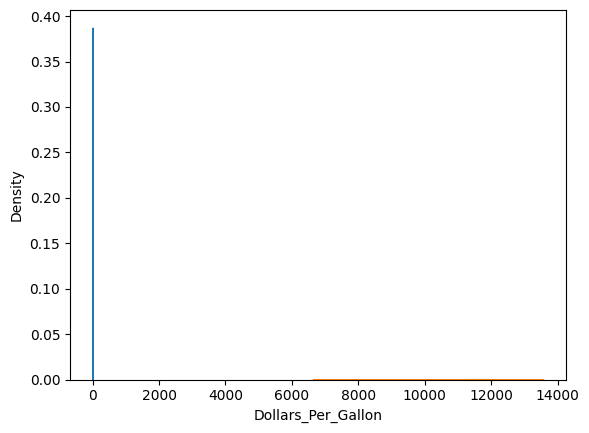

In [465]:
import seaborn as sns
sns.kdeplot(merged_df["Dollars_Per_Gallon"], fill=True)
sns.kdeplot(merged_df["Gasoline_Consumption(Millions of Gallons)"], fill=True)

## Visualizing Merged Datasets

In [466]:
''' Create dual-axis line plot for consumption and price '''

# Create figure with secondary y-axis
fig.update_layout(
    title="U.S. Gasoline Consumption vs Price (Nominal, 1993-2024)",
    xaxis=dict(title="Year"),
    yaxis=dict(
        title=dict(
            text="Gasoline Consumption (Millions of Gallons)",
            font=dict(color="steelblue")
        ),
        tickfont=dict(color="steelblue")
    ),
    yaxis2=dict(
        title=dict(
            text="Gasoline Price (USD per Gallon)",
            font=dict(color="firebrick")
        ),
        tickfont=dict(color="firebrick"),
        overlaying="y",
        side="right"
    ),
    template="plotly_white",
    legend=dict(x=0.01, y=0.99, bgcolor="rgba(255,255,255,0.8)"),
    title_x=0.5,
    height=600
)

if using the extra data, efficiency go up over time which could mean increased destination but reduced or constant consumption